# 1 Setup

In [65]:
import pandas as pd
import numpy as np
import re
import string
import math
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem import PorterStemmer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import sys
from matplotlib import pyplot as plt

In [66]:
bug_reports_filename = './Output/allBugReports.pickle'
bug_reports_df = pd.read_pickle(bug_reports_filename)

source_code_filename = './Output/allSourceCodes.pickle'
source_code_df = pd.read_pickle(source_code_filename)

# 2 Preprocessing

This section is for cleaning the data within `bug_reports_df` and `source_code_df`. The text within the dataframes will be cleaned, and samples with empty/unusable data will be removed. All functions used for preprocessing will be defined in this sections and we will also run those functions in this section.

In [67]:
bug_reports_df.head()


,fix,text,fixdate,summary,description,project,average_precision
id,,,,,,,
23,[org.springframework.data.rest.webmvc.reposito...,NaN,2012-07-31 11:48:16,Searches which returns null gives NPE,A search which returns null gives NullPointerE...,DATAREST,0.0
21,[org.springframework.data.rest.webmvc.reposito...,NaN,2012-07-31 11:49:25,paging with parameters,missing parameter findBy in href .prev and .ne...,DATAREST,0.0
41,[org.springframework.data.rest.webmvc.json.rep...,NaN,2012-09-05 06:07:58,No update on objects,"When I try to update an object, the only think...",DATAREST,0.0
45,[org.springframework.data.rest.webmvc.entityto...,NaN,2012-09-05 06:09:20,No IDs in href of objects displayed,Browsing to: http://localhost:8080/rest/sla re...,DATAREST,0.0
38,[org.springframework.data.rest.webmvc.reposito...,NaN,2012-09-05 06:29:43,Listing relations with Accept:application/x-sp...,When loading a relation like this: \nhttp://lo...,DATAREST,0.0


In [68]:
source_code_df.head()

,filename,unprocessed_code,project
0,test.java.org.springframework.data.rest.webmvc...,/*\n * Copyright 2015 the original author or a...,DATAREST
1,test.java.org.springframework.data.rest.webmvc...,/*\n * Copyright 2015-2016 the original author...,DATAREST
2,main.java.org.springframework.data.rest.webmvc...,/*\n * Copyright 2015-2016 the original author...,DATAREST
3,test.java.org.springframework.data.rest.webmvc...,package org.springframework.data.rest.webmvc;\...,DATAREST
4,test.java.org.springframework.data.rest.webmvc...,/*\n * Copyright 2014-2015 the original author...,DATAREST


## 2.1 Functions for pre-processing

Source Code Data Pre-processing:
- Remove new lines
- Remove Comments in /* */ notation
- Remove punctuation
- Remove stop words (incuding common java words)
- Stem words
- Clean filenames to match bug report filenames

Bug Report Data Pre-processing:
- Remove new lines
- Remove punctuation
- Remove stop words (incuding common java words)
- Stem words


In [69]:
# Java key words found in https://docs.oracle.com/javase/tutorial/java/nutsandbolts/_keywords.html
java_keywords = ["abstract", "assert**","assert", "boolean", "break", "byte",
 "case", "catch", "char", "const", "continue", "default", "do", "double", "else", "enum",
  "enum****" "extends", "final", "finally", "for", "goto","goto*", "if", "implements", "import", 
  "instanceof", "int","interface", "long", "native", "new", "package", "private", "protected",
   "public", "return", "short", "static", "strictfp**","strictfp", "super", "switch", "synchornized", 
   "this", "throw", "throws", "transient", "try", "void", "volatile", "while"]

# Java operators found in https://www.tutorialspoint.com/java/java_basic_operators.htm
java_operators = ["+", "-", "*", "/", "%", "+=", "-=", "*=", "/=", "++", "--", "==", "!=", "<", ">", 
"<=", ">=", ".", "[", "]", "(",")", "!", "~", "<<", ">>", ">>>", "&", "^", "|", "&&", "||",
 "?", ":", "^=", "%=", "<<=", ">>=", ">>>=", "&="]

java_stop_words = java_keywords + java_operators
ALL_STOP_WORDS = ENGLISH_STOP_WORDS.union(java_stop_words)

### Functions for cleaning text

In [70]:
# Split camel case text from source code
def split_camel_case(text):
  words = text.split(' ')
  result = []
  
  for word in words:
    if len(word):
      # regex from https://stackoverflow.com/questions/29916065/how-to-do-camelcase-split-in-python
      result = result + re.split("(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])", word)
   
  return ' '.join(result)

# Remove any single or trailing '.' leftover from remove_punctuation() function
def remove_trailing_and_single_dots(text):
  words = text.split(' ')
  result = []
  for word in words:
    if len(word) and word[-1] == '.':
      word = word[:-1]
    if len(word) and word[0] == '.':
      word = word[1:]
    result.append(word)
  
  return ' '.join(result)

# Remove all punctuation except '.'
def remove_punctuation(text):
  punctuation = "/:;<=>?@[\]^_`{|}~!\"#$%&'()*+,-"
  result = re.sub('['+punctuation+']', ' ', text)
  result = remove_trailing_and_single_dots(result)
  result = re.sub("\s+", ' ', result)
  return result

# User regex to remove comments using /* */ notation
def remove_comments(text):
  # regex found at https://blog.ostermiller.org/finding-comments-in-source-code-using-regular-expressions/
  result = re.sub("/\*([^*]|[\r\n]|(\*+([^*/]|[\r\n])))*\*+/", '', text)
  return result

# Remove all new lines from text
def remove_new_lines(text):
  result = []
  for line in text.splitlines():
    if len(line) <= 0:
      continue
    result.append(line)
  result = ' '.join(result)
  result = re.sub('\s+', ' ', result)
  return result

# Remove all stop words and stem remaining words
def stem_words(text):
  stemmer = PorterStemmer()
  words = text.split(' ')
  result = []
  for word in words:
      if word not in ALL_STOP_WORDS:
          result.append(stemmer.stem(word))
  result = ' '.join(result)
  return result

In [71]:
# Start pipeline for cleaning unprocessed code
def clean_unprocessed_code(text):
    # Remove new line breaks
    result = remove_new_lines(text)

    # Remove comments
    result = remove_comments(result)

    # Remove punctuation
    result = remove_punctuation(result)

    # Remove camelCase
    result = split_camel_case(result)

    # Lowercase
    result = result.lower()

    # Stem words
    result = stem_words(result)

    return result.strip()

# Start pipeline for cleaning bug report descriptions
def clean_bug_reports(text):
    if not text:
        return ''
    # Remove new line breaks
    result = remove_new_lines(text)

    # Remove punctuation
    result = remove_punctuation(result)

    # Remove camelCase
    result = split_camel_case(result)

    # Lowercase
    result = result.lower()

    # Stem words
    result = stem_words(result)

    return result.strip()
    

### Functions for cleaning filenames

In [72]:
# Fix source code filenames to match filenames in bug reports
def fix_sc_filename(sc_df):
    filename = sc_df[0]
    proj = sc_df[2]
    file = filename.split(".")
    if proj == 'IO' or proj == 'COLLECTIONS':
        file = '.'.join(file[1:])
    else:
        file = '.'.join(file[2:])
    return file

## 2.2 Run preprocessing functions on data

In [73]:
# Note: This cell takes 1 minute to run

# Clean source code
source_code_df['processed_code'] = source_code_df.unprocessed_code.apply(clean_unprocessed_code)
source_code_df.head()

,filename,unprocessed_code,project,processed_code
0,test.java.org.springframework.data.rest.webmvc...,/*\n * Copyright 2015 the original author or a...,DATAREST,org.springframework.data.rest.webmvc.halbrows ...
1,test.java.org.springframework.data.rest.webmvc...,/*\n * Copyright 2015-2016 the original author...,DATAREST,org.springframework.data.rest.webmvc.halbrows ...
2,main.java.org.springframework.data.rest.webmvc...,/*\n * Copyright 2015-2016 the original author...,DATAREST,org.springframework.data.rest.webmvc.halbrows ...
3,test.java.org.springframework.data.rest.webmvc...,package org.springframework.data.rest.webmvc;\...,DATAREST,org.springframework.data.rest.webmvc org.hamcr...
4,test.java.org.springframework.data.rest.webmvc...,/*\n * Copyright 2014-2015 the original author...,DATAREST,org.springframework.data.rest.webmvc org.hamcr...


In [74]:
# Clean bug reports
bug_reports_df['summary'] = bug_reports_df.summary.apply(clean_bug_reports)
bug_reports_df['description'] = bug_reports_df.description.apply(clean_bug_reports)
bug_reports_df["query"] = bug_reports_df["summary"] + bug_reports_df["description"]
bug_reports_df.head()

,fix,text,fixdate,summary,description,project,average_precision,query
id,,,,,,,,
23,[org.springframework.data.rest.webmvc.reposito...,NaN,2012-07-31 11:48:16,search return null give npe,search return null give null pointer except re...,DATAREST,0.0,search return null give npesearch return null ...
21,[org.springframework.data.rest.webmvc.reposito...,NaN,2012-07-31 11:49:25,page paramet,miss paramet href prev page lt loan info gt ns...,DATAREST,0.0,page parametmiss paramet href prev page lt loa...
41,[org.springframework.data.rest.webmvc.json.rep...,NaN,2012-09-05 06:07:58,updat object,updat object think happen select persist objec...,DATAREST,0.0,updat objectupdat object think happen select p...
45,[org.springframework.data.rest.webmvc.entityto...,NaN,2012-09-05 06:09:20,ds href object display,brows http localhost 8080 rest sla result gist,DATAREST,0.0,ds href object displaybrows http localhost 808...
38,[org.springframework.data.rest.webmvc.reposito...,NaN,2012-09-05 06:29:43,list relat accept applic x spring data compact...,load relat like http localhost 8080 rest entit...,DATAREST,0.0,list relat accept applic x spring data compact...


In [75]:
# Fix source code filenames
source_code_df['filename'] = source_code_df.apply(fix_sc_filename, axis=1)

## 2.3 Further clean data by removing unusable data duplicate

- There are files in the bug reports that are not in the source code files
- There is duplicate data in the source code data that is not needed

We want to remove all this data to fully test the fault localization algorithm since these files will not be found by the algorithm due to missing data (not actually due to the accuracy of the algorithm)

In [76]:
# Remove duplicate data in the source code data
def remove_duplicate_files(filename, currently_seen):
    if filename in currently_seen:
        return False
    currently_seen.add(filename)
    return True

# Remove files that are found in bug report but not in source code
def remove_missing_projects(fixes, src_code_dict):
    result = []
    for fix in fixes:
        if fix in src_code_dict:
            result.append(fix)
    return result

# Remove bug report samples that have all files 
# removed by remove_missing_projects() function
def get_missing_data_bool_mask(fixes):
    if len(fixes) <= 0:
        return False
    return True

In [77]:
# Remove duplicate data in source code dataframe
currently_seen = set()
sc_bool_mask = list(map(lambda r: remove_duplicate_files(r, currently_seen), source_code_df.filename))
source_code_df = source_code_df[sc_bool_mask]

In [78]:
src_code_dict = {}
for idx, row in source_code_df.iterrows():
    src_code_dict[row.filename] = idx

# Remove projects that are not seen in source code dataframe
bug_reports_df['fix'] = bug_reports_df.fix.apply(lambda r: remove_missing_projects(r, src_code_dict))
# Create a bool mask to filter bug reports that have no fix files
br_bool_mask = list(map(get_missing_data_bool_mask, bug_reports_df.fix))
bug_reports_df = bug_reports_df[br_bool_mask]

# 3 Similarity and Evaluation Functions

This section contains all the functions used by `method 1` and `method 2` for calculating similarity scores and evaluating the algorithm. The functions here will be shared by both methods.

## 3.1 Setup

In [79]:
projects = source_code_df.project.unique()
source_code_grouped = source_code_df.groupby(source_code_df.project)
bug_reports_grouped = bug_reports_df.groupby(bug_reports_df.project)

In [80]:
print(projects)

['DATAREST' 'CONFIGURATION' 'SEC' 'LDAP' 'IO' 'ELY' 'LANG' 'SPR'
 'DATACMNS' 'SOCIALFB' 'DATAMONGO' 'COLLECTIONS']


## 3.2 Functions for Calculating Similarities

In [81]:
# Normalize terms using Equation (6)
def normalize_terms(terms):
    x_min = min(terms)
    x_max = max(terms)
    for idx, x in enumerate(terms):
        normalized_term = (x - x_min)/(x_max - x_min)
        terms[idx] = normalized_term

# Run Equation (5) on # of terms
def inverse_logit_function(terms):
    for idx, term in enumerate(terms):
        inverse_term = 1 / (1 + math.exp(-1 * term))
        terms[idx] = inverse_term

# Calculate rVSM function using Equation (7)
def calc_rVSM(document, query, gterms):
    result = cosine_similarity(query, document).flatten()
    for i in range(len(result)):
        result[i] = gterms[i] * result[i]

    return result

# Run pipeline for calculating direct similarities
def check_direct_similarities(source_code, queries, vect):
    scores = []

    sc_vect = vect.transform(source_code['processed_code'])

    # Get all terms
    terms = []
    for doc in source_code['processed_code']:
        terms.append(len(set(doc.split(' '))))

    # Run Equation (5) and Equation (6)
    normalize_terms(terms)
    inverse_logit_function(terms)
    
    # For each query, calculate similarity that query has to every source code file
    for query in queries['query']:
        qr_vect = vect.transform([query])
        rVSM_score = calc_rVSM(sc_vect, qr_vect, terms)
        scores.append(rVSM_score)

    return scores

In [82]:
# Calculate simi score using Equation (8)
# Input:
#   proj_src_dict: Dictionary of source files
#   fixes: Array of fixes for each bug
#   bug_similarities: array of scores calculated by cosine similarity
# Output:
#   returns array of similarity scores for each source code file
def calc_simi_score(proj_src_dict, fixes, bug_similarities):
    # print(len(fixes), len(bug_similarities))
    src_code_similarites = [0 for _ in proj_src_dict.keys()]
    # print(len(src_code_similarites))
    for idx, bug_sim in enumerate(bug_similarities):
        if bug_sim == 1:
                continue
        for fix_file in fixes[idx]:
            key = proj_src_dict[fix_file]
            src_code_similarites[key] += bug_sim/len(fixes[idx])

    return src_code_similarites

# Run pipeline for calculating indirect similarities
# Input:
#   sc_project_df: source code dataframe
#   queries: bug report dataframe
#   vect: TD-IDF vector
# Output:
#   returns array of scores for each query in queries
def check_indirect_similarities(sc_project_df, queries, vect):
    scores = []
    all_qr_vect = vect.transform(queries['query'])

    proj_src_dict = {}
    idx = 0
    for _, row in sc_project_df.iterrows():
        proj_src_dict[row.filename] = idx
        idx += 1

    # For each query, calculate indirect similarity
    for query in queries['query']:
        qr_vect = vect.transform([query])
        qr_bug_similarities = cosine_similarity(qr_vect, all_qr_vect).flatten()
        simi_score = calc_simi_score(proj_src_dict, queries.fix, qr_bug_similarities)
        scores.append(simi_score)

    return scores

## 3.3 Functions for Evaluation

In [83]:
# Input: 
#   scores: Array of scores created by cosine similarity function
# Output:
#   Array of score indexes sorted in descending order
def rank_scores(scores):
    sorted_scores = np.array(scores).argsort()
    return np.flip(sorted_scores)

# Description: 
#   Map fix files to files in source code (if there is one)
# Input: 
#   fixes: Array of filenames representing the fixes of bugs
#   filenames:  Array of filenames representing the source code files
# Output:
#   result: Array of indexes that map the respective fix file to the file in the source code
def get_fix_index(fixes, filenames):
    result = []
    for fix in fixes:
        fix_index = -1
        for idx, filename in enumerate(filenames):
            if filename == fix:
                fix_index = idx
                break
        result.append(fix_index)
    return result


In [84]:
# Description:
#   Finds where the fix files are in the ranking given by the cosine similarity
# Input: 
#   fixes_idx: Array of indexes created by get_fix_index()
#   file_rankings: Array of indexes created by rank_scores()
# Output:
#   result: Array of indexes that map the fix file to the ranking given by the cosine similarity
def get_fix_rank(fixes_idx, file_rankings):
    result = []
    for fix_idx in fixes_idx:
        for idx, rank in enumerate(file_rankings):
            if fix_idx == rank:
                fix_file_rank = idx + 1
                result.append(fix_file_rank)
                break
    return result

# Description:
#   Calculates the reciprocal rank of the query given the ranks of the cosine similarity
# Input:
#   ranks: Array of indexes created by get_fix_rank()
# Output:
#   returns the reciprocal rank of the query
def calc_reciprocal_rank(ranks):
    sorted_ranks = sorted(ranks)
    if len(sorted_ranks) > 0:
        return 1/(sorted_ranks[0])

# Description:
#   Calcualtes the average precision of the query fiven the ranks of the cosine similarity
# Input:
#   ranks: Array of indexes created by get_fix_rank()
# Output:
#   returns the average accuracy of the query
def calc_mean_average_precision(ranks):
    sorted_ranks = sorted(ranks)
    pos_instances = 0
    result = 0
    for rank in sorted_ranks:
        if rank == sys.maxsize:
            break
        pos_instances += 1
        result += pos_instances/rank
        
    if pos_instances != 0: 
        return result/pos_instances
    else:
        return 0


## 3.4 Pipeline for running algorithms and evaluation

In [85]:
# Pipeline for running evaluation for scores
def run_eval(sc_project_df, br_project_df, scores, my_dict):
    fix_rank = []
    reciprocal_rank = []
    average_precision = []

    idx = 0
    for _, row in br_project_df.iterrows():
        ranked_scores = rank_scores(scores[idx])
        fix_index = get_fix_index(row.fix, sc_project_df.filename)
        fix_r = get_fix_rank(fix_index, ranked_scores)
        fix_rank.append(fix_r)
        reciprocal_rank.append(calc_reciprocal_rank(fix_r))
        average_precision.append(calc_mean_average_precision(fix_r))
        idx += 1
    
    my_dict['fix_rank'] = fix_rank
    my_dict['reciprocal_rank'] = reciprocal_rank
    my_dict['average_precision'] = average_precision


In [86]:
# Run pipeline for calculating direct similarities and evaluation
def start_alg_direct():
    result = {}
    
    for proj in projects:
        proj_dict = {name: [] for name in ('score', 'fix_rank', 'reciprocal_rank', 'average_precision')}
        # get project group for current group
        sc_project_df = source_code_grouped.get_group(proj)
        br_project_df = bug_reports_grouped.get_group(proj)

        # Create TF-IDF vectorizer
        vect = TfidfVectorizer(min_df=1).fit(sc_project_df['processed_code'])

        # Calculate direct score
        scores = check_direct_similarities(sc_project_df, br_project_df, vect)
        proj_dict['score'] = scores

        # Calculate MAP, MRR and other metrics for given data
        run_eval(sc_project_df, br_project_df, scores, proj_dict)

        result[proj] = proj_dict.copy()

    return result

In [87]:
# Run pipeline for calculating indirect similarities and evaluation
def start_alg_indirect():
    result = {}
    
    for proj in projects:
        proj_dict = {name: [] for name in ('score', 'fix_rank', 'reciprocal_rank', 'average_precision')}
        # get project group for current group
        sc_project_df = source_code_grouped.get_group(proj)
        br_project_df = bug_reports_grouped.get_group(proj)

        # Create TF-IDF vectorizer
        vect = TfidfVectorizer(min_df=1).fit(sc_project_df['processed_code'])

        # Calculate indirect score
        simi_scores = check_indirect_similarities(sc_project_df, br_project_df, vect)
        proj_dict['score'] = simi_scores

        # Calculate MAP, MRR and other metrics for given data
        run_eval(sc_project_df, br_project_df, simi_scores, proj_dict)

        result[proj] = proj_dict.copy()

    return result

# 4 Method 1

This sections we will calculate method 1 using only direct similiarity scores. This sections contains all the visualizations for method 1.

## 4.1 Get scores

In [88]:
method_1_scores = start_alg_direct()

In [89]:
method_1_df = pd.DataFrame(method_1_scores).transpose()
method_1_df.head()

,score,fix_rank,reciprocal_rank,average_precision
DATAREST,"[[0.061959157013992266, 0.07685805325479289, 0...","[[90], [47, 306, 334], [215], [200], [321], [2...","[0.011111111111111112, 0.02127659574468085, 0....","[0.011111111111111112, 0.012264859795080955, 0..."
CONFIGURATION,"[[0.05121419785394934, 0.04454529906745555, 0....","[[29, 3, 6], [5, 1], [41, 8], [14, 45, 1], [10...","[0.3333333333333333, 1.0, 0.125, 1.0, 0.142857...","[0.2567049808429119, 0.7, 0.08689024390243902,..."
SEC,"[[0.01465911315724627, 0.0022996999313322198, ...","[[11], [10, 440, 1, 268], [9, 685, 10, 313], [...","[0.09090909090909091, 1.0, 0.1111111111111111,...","[0.09090909090909091, 0.3050712347354138, 0.08..."
LDAP,"[[0.013259834326026043, 0.013272889903065323, ...","[[7], [1], [1, 3], [6, 3], [2], [1, 2], [3], [...","[0.14285714285714285, 1.0, 1.0, 0.333333333333...","[0.14285714285714285, 1.0, 0.8333333333333333,..."
IO,"[[0.06221335981731066, 0.011352761496075501, 0...","[[27, 3], [2, 1], [1, 2], [2, 4], [1], [5, 2, ...","[0.3333333333333333, 1.0, 1.0, 0.5, 1.0, 0.5, ...","[0.2037037037037037, 1.0, 1.0, 0.5, 1.0, 0.292..."


## 4.2 Create Performance Table

In [90]:
def calculate_top_k(ranks, k):
    if len(ranks) <= 0:
        return

    top_k = 0
    # If at least 1 bug is found in top k, then we count it as success (according to research paper)
    for rank in ranks:
        if len(list(filter(lambda r: r <= k, rank))) > 0:
            top_k += 1

    return top_k, top_k/len(ranks) * 100

def create_performance_table(proj_row):
    result = []
    # array to variables
    ranks = proj_row[1]
    rr = proj_row[2]
    ap = proj_row[3]

    # Calculate MRR
    score_MRR = np.mean(rr)
    result.append(score_MRR)

    # Calculate MAP
    score_MAP = np.mean(ap)
    result.append(score_MAP)

    # Calcualte Top 1%
    top_1, top_1_percent = calculate_top_k(ranks, 1)
    result.append(int(top_1))
    result.append(top_1_percent)

    # Calcualte Top 5%
    top_5, top_5_percent = calculate_top_k(ranks, 5)
    result.append(top_5)
    result.append(top_5_percent)

    # Calcualte Top 10%
    top_10, top_10_percent = calculate_top_k(ranks, 10)
    result.append(top_10)
    result.append(top_10_percent)

    return pd.Series(result)

In [91]:
method_1_performance_table_df = method_1_df.apply(create_performance_table, axis=1)
method_1_performance_table_df.columns = ['MRR', 'MAP', 'Top 1', 'Top 1 (%)', 'Top 5', 'Top 5 (%)', 'Top 10', 'Top 10 (%)']

In [92]:
method_1_performance_table_df.head(12)

,MRR,MAP,Top 1,Top 1 (%),Top 5,Top 5 (%),Top 10,Top 10 (%)
DATAREST,0.477968,0.317208,41.0,34.453782,75.0,63.025210,89.0,74.789916
CONFIGURATION,0.568746,0.399042,53.0,43.801653,89.0,73.553719,106.0,87.603306
SEC,0.443140,0.353154,108.0,30.167598,227.0,63.407821,264.0,73.743017
LDAP,0.452596,0.354167,16.0,30.769231,31.0,59.615385,35.0,67.307692
IO,0.733792,0.693688,40.0,58.823529,62.0,91.176471,65.0,95.588235
ELY,0.630952,0.630952,3.0,42.857143,7.0,100.000000,7.0,100.000000
LANG,0.664944,0.589924,86.0,53.086420,136.0,83.950617,148.0,91.358025
SPR,0.206079,0.128763,13.0,10.000000,41.0,31.538462,56.0,43.076923
DATACMNS,0.528252,0.415011,58.0,40.000000,97.0,66.896552,107.0,73.793103
SOCIALFB,0.538475,0.436705,6.0,40.000000,10.0,66.666667,13.0,86.666667


## 4.3 Visualization Functions

In [93]:
def visualize_top_k_percent(df):
    proj_x = df.index.to_numpy()
    top_1 = df['Top 1 (%)'].to_numpy()
    top_5 = df['Top 5 (%)'].to_numpy()
    top_10 = df['Top 10 (%)'].to_numpy()

    x_pos = np.arange(len(proj_x))
    plt.figure(figsize=(20,10))
    plt.xticks(x_pos, proj_x)
    width = 0.25
    plt.title('Top k percentages of bug location ranks')
    plt.ylabel('Percentage (%)')
    plt.ylim(0, 110)
    plt.bar(x_pos - width, top_1, width=width, label='Top 1 (%)')
    plt.bar(x_pos, top_5,  width=width, label='Top 5 (%)')
    plt.bar(x_pos + width, top_10,  width=width, label='Top 10 (%)')
    plt.legend()

def visualize_MAP_or_MRR(df, data_metric):
    proj_x = df.index.to_numpy()
    metric = df[data_metric].to_numpy()

    x_pos = np.arange(len(proj_x))
    plt.figure(figsize=(20,10))
    plt.xticks(x_pos, proj_x)
    plt.title(f'{data_metric} for each project')
    plt.ylabel('Percentage (%)')
    plt.ylim(0, 1.1)
    plt.bar(x_pos, metric, label=f'{data_metric}')
    plt.legend()

## 4.4 Create Graphs

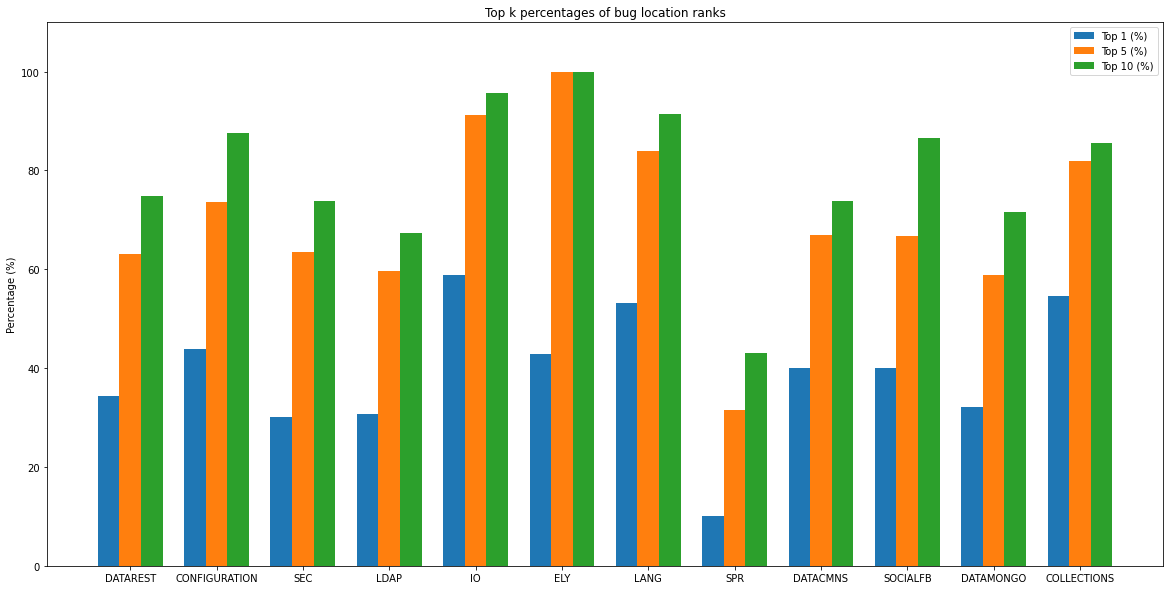

In [94]:
visualize_top_k_percent(method_1_performance_table_df)

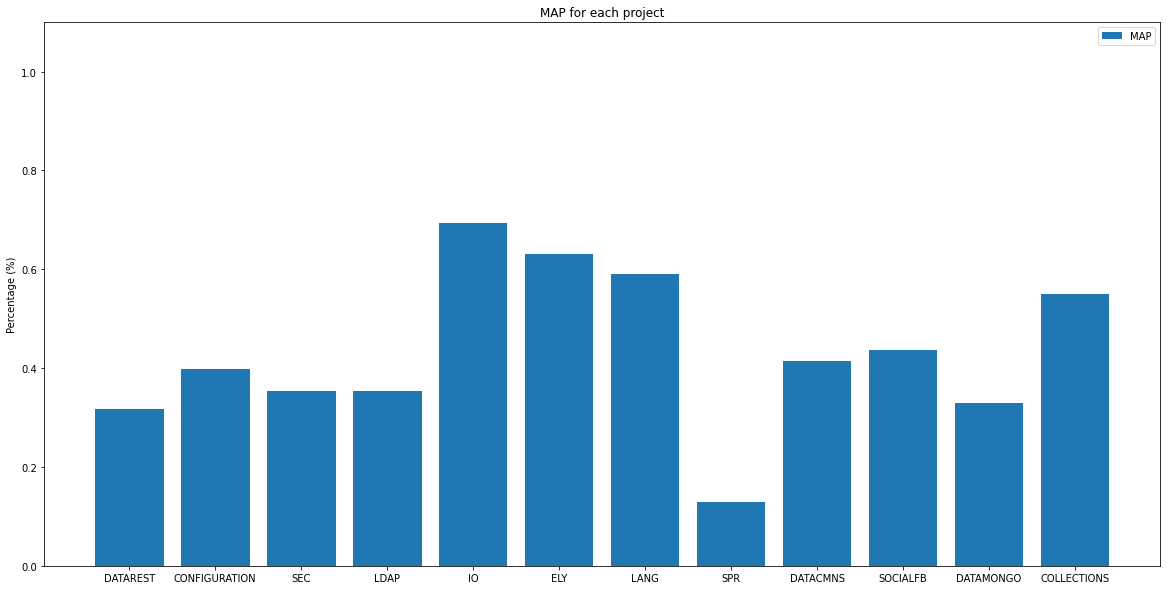

In [95]:
visualize_MAP_or_MRR(method_1_performance_table_df, 'MAP')

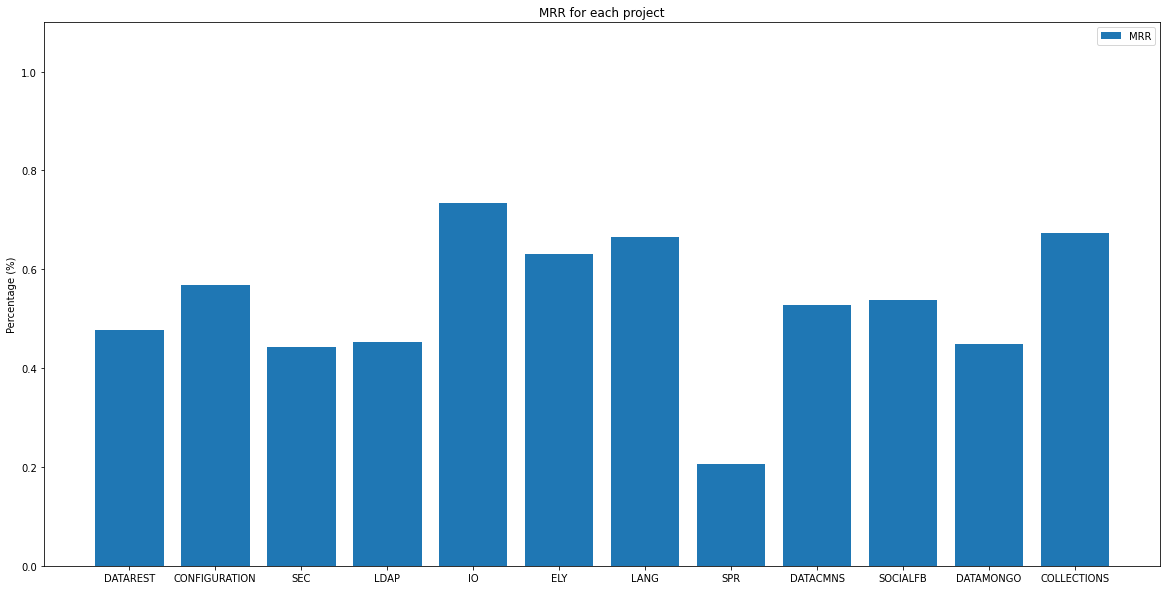

In [96]:
visualize_MAP_or_MRR(method_1_performance_table_df, 'MRR')

# 5 Method 2

This sections we will calculate method 2 using both direct and indirect similiarity scores. This sections contains all the visualizations for method 2.

## 5.1 Calculate scores

In [97]:
direct_scores = start_alg_direct()
indirect_scores = start_alg_indirect()

## 5.2 Combine direct and indirect scores

In [98]:
# Calcualte final score using Equation (9)
def calc_final_score(direct_scores, indirect_scores, alpha):
    direct_alpha_scores = list(map(lambda r: np.array(r)*(1-alpha), direct_scores))
    indirect_alpha_scores = list(map(lambda r: np.array(r)*alpha, indirect_scores))
    return np.array(direct_alpha_scores) + np.array(indirect_alpha_scores)

# Run pipeline to combine the direct and indirect scores
def combine_scores(direct_scores, indirect_scores):
    result = {}
    
    for alpha in range(0, 11):
        alpha_dict = {name: {} for name in projects}
        for proj in projects:
            proj_dict = {name: [] for name in ('score', 'fix_rank', 'reciprocal_rank', 'average_precision')}
            sc_project_df = source_code_grouped.get_group(proj)
            br_project_df = bug_reports_grouped.get_group(proj)
            direct_proj_scores = direct_scores[proj]['score'].copy()
            indirect_proj_scores = indirect_scores[proj]['score'].copy()

            # Normalize all scores for each query
            for arr in direct_proj_scores:
                normalize_terms(arr)

            for arr in indirect_proj_scores:
                normalize_terms(arr)

            # Calculate final score using Equation (9)
            final_scores = calc_final_score(direct_proj_scores, indirect_proj_scores, alpha/10)
            proj_dict['score'] = final_scores

            # Run evaluations on final score
            run_eval(sc_project_df, br_project_df, final_scores, proj_dict)

            alpha_dict[proj] = proj_dict.copy()
        
        if alpha == 10:
            result['1.0'] = alpha_dict.copy()
        else:
            result[f'0.{alpha}'] = alpha_dict.copy()
    
    # Return array of combined scores for each alpha value
    return result


In [99]:
combined_eval_scores = combine_scores(direct_scores, indirect_scores)

In [100]:
# Create a data frame for each alpha value score and store into an array
all_combined_alpha_df = []
for alpha in ['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0',]:
    all_combined_alpha_df.append(pd.DataFrame(combined_eval_scores[alpha]).transpose())

In [101]:
all_combined_alpha_df[10].head(3)

,score,fix_rank,reciprocal_rank,average_precision
DATAREST,"[[0.09712246475617524, 0.05664361110521081, 0....","[[32], [5, 4, 1], [1], [1], [1], [10, 3, 5, 8,...","[0.03125, 1.0, 1.0, 1.0, 1.0, 0.33333333333333...","[0.03125, 0.7000000000000001, 1.0, 1.0, 1.0, 0..."
CONFIGURATION,"[[0.0, 0.0029475848367484197, 0.26049528761628...","[[6, 8, 9], [2, 1], [4, 1], [32, 1, 31], [3, 2...","[0.16666666666666666, 1.0, 1.0, 1.0, 0.5, 0.14...","[0.25, 1.0, 0.75, 0.3860887096774193, 0.583333..."
SEC,"[[0.0, 0.0, 0.004431155407025246, 0.0043422652...","[[3], [24, 23, 22, 3], [8, 9, 7, 1], [1, 2], [...","[0.3333333333333333, 0.3333333333333333, 1.0, ...","[0.3333333333333333, 0.18033596837944663, 0.52..."


## 5.3 Creating Performance Tables

In [102]:
def calculate_top_k(ranks, k):
    if len(ranks) <= 0:
        return

    top_k = 0
    # If at least 1 bug is found in top k, then we count it as success (according to research paper)
    for rank in ranks:
        if len(list(filter(lambda r: r <= k, rank))) > 0:
            top_k += 1

    return top_k, top_k/len(ranks) * 100

def create_performance_table(proj_row):
    result = []
    # array to variables
    ranks = proj_row[1]
    rr = proj_row[2]
    ap = proj_row[3]

    # Calculate MRR
    score_MRR = np.mean(rr)
    result.append(score_MRR)

    # Calculate MAP
    score_MAP = np.mean(ap)
    result.append(score_MAP)

    # Calcualte Top 1%
    top_1, top_1_percent = calculate_top_k(ranks, 1)
    result.append(int(top_1))
    result.append(top_1_percent)

    # Calcualte Top 5%
    top_5, top_5_percent = calculate_top_k(ranks, 5)
    result.append(top_5)
    result.append(top_5_percent)

    # Calcualte Top 10%
    top_10, top_10_percent = calculate_top_k(ranks, 10)
    result.append(top_10)
    result.append(top_10_percent)

    return pd.Series(result)

In [103]:
# For each alpha value dataframe, create a performance table for it and store them all in an array
all_combined_alpha_performance_table = []
for alpha_df in all_combined_alpha_df:
    alpha_performance_table = alpha_df.apply(create_performance_table, axis=1)
    alpha_performance_table.columns = ['MRR', 'MAP', 'Top 1', 'Top 1 (%)', 'Top 5', 'Top 5 (%)', 'Top 10', 'Top 10 (%)']
    all_combined_alpha_performance_table.append(alpha_performance_table)

In [104]:
# Example of performance table for alpha=1.0
all_combined_alpha_performance_table[10].head(3)

,MRR,MAP,Top 1,Top 1 (%),Top 5,Top 5 (%),Top 10,Top 10 (%)
DATAREST,0.666521,0.548444,64.0,53.781513,96.0,80.672269,103.0,86.554622
CONFIGURATION,0.630037,0.558202,62.0,51.239669,96.0,79.338843,105.0,86.776860
SEC,0.521166,0.472427,151.0,42.178771,229.0,63.966480,262.0,73.184358


## 5.4 Comparing data from all Alpha Values

In [105]:
# Given a data metric, combine all alpha values into one table
def compare_alpha_data(all_alpha_tables, data_metric):
    result = []
    result.append(all_alpha_tables[0].index)
    for alpha_val, alpha_table in enumerate(all_alpha_tables):
        data_series = alpha_table[data_metric].to_numpy()
        result.append(data_series)
    
    df = pd.DataFrame(result).transpose()
    df.columns = ['Project', f'{data_metric} alpha=0.0', f'{data_metric} alpha=0.1', f'{data_metric} alpha=0.2',
        f'{data_metric} alpha=0.3', f'{data_metric} alpha=0.4', f'{data_metric} alpha=0.5', f'{data_metric} alpha=0.6',
        f'{data_metric} alpha=0.7', f'{data_metric} alpha=0.8', f'{data_metric} alpha=0.9', f'{data_metric} alpha=1.0',]
    df = df.set_index('Project')
    return df


In [106]:
alpha_MAP = compare_alpha_data(all_combined_alpha_performance_table, 'MAP')
alpha_MAP.head(12)

,MAP alpha=0.0,MAP alpha=0.1,MAP alpha=0.2,MAP alpha=0.3,MAP alpha=0.4,MAP alpha=0.5,MAP alpha=0.6,MAP alpha=0.7,MAP alpha=0.8,MAP alpha=0.9,MAP alpha=1.0
Project,,,,,,,,,,,
DATAREST,0.317208,0.365015,0.428875,0.498455,0.547353,0.570582,0.591987,0.579332,0.572797,0.559372,0.548444
CONFIGURATION,0.399042,0.452053,0.516513,0.572548,0.615073,0.636309,0.620594,0.598691,0.587753,0.572389,0.558202
SEC,0.353154,0.420287,0.486531,0.530553,0.555699,0.569057,0.558612,0.535648,0.513767,0.492821,0.472427
LDAP,0.354167,0.422255,0.485728,0.539876,0.61602,0.631604,0.649932,0.657577,0.646952,0.638715,0.617243
IO,0.693688,0.724126,0.753983,0.79534,0.803834,0.789763,0.774592,0.746473,0.73022,0.717386,0.698174
ELY,0.630952,0.72619,0.797619,0.833333,0.928571,1.0,1.0,1.0,1.0,1.0,1.0
LANG,0.589924,0.627724,0.673341,0.713809,0.758141,0.781122,0.755596,0.733756,0.701326,0.662594,0.627571
SPR,0.128763,0.196832,0.290117,0.393497,0.547638,0.636403,0.650781,0.62816,0.612083,0.592696,0.576391
DATACMNS,0.415011,0.485131,0.562213,0.600924,0.647251,0.672555,0.659346,0.644121,0.634627,0.617517,0.60362


In [107]:
alpha_MRR = compare_alpha_data(all_combined_alpha_performance_table, 'MRR')
alpha_MRR.head(12)

,MRR alpha=0.0,MRR alpha=0.1,MRR alpha=0.2,MRR alpha=0.3,MRR alpha=0.4,MRR alpha=0.5,MRR alpha=0.6,MRR alpha=0.7,MRR alpha=0.8,MRR alpha=0.9,MRR alpha=1.0
Project,,,,,,,,,,,
DATAREST,0.477968,0.521898,0.576348,0.657716,0.718774,0.726669,0.736187,0.70407,0.683671,0.672849,0.666521
CONFIGURATION,0.568746,0.635681,0.698997,0.745002,0.754195,0.744224,0.711887,0.682158,0.663795,0.64052,0.630037
SEC,0.44314,0.510655,0.573962,0.61531,0.628495,0.629543,0.606553,0.579095,0.559766,0.539484,0.521166
LDAP,0.452596,0.555071,0.620121,0.653548,0.74764,0.75665,0.742271,0.734816,0.719311,0.708072,0.693878
IO,0.733792,0.759191,0.789128,0.826096,0.833421,0.825327,0.792938,0.757884,0.749673,0.732353,0.710961
ELY,0.630952,0.714286,0.785714,0.857143,0.928571,1.0,1.0,1.0,1.0,1.0,1.0
LANG,0.664944,0.689503,0.725478,0.758797,0.803694,0.823212,0.777601,0.757462,0.717782,0.67399,0.64517
SPR,0.206079,0.293296,0.417647,0.555048,0.702242,0.74179,0.705155,0.658677,0.625947,0.601024,0.581532
DATACMNS,0.528252,0.592284,0.660971,0.690838,0.725533,0.740985,0.721575,0.701476,0.685886,0.670269,0.658984


## 5.5 Visualization Functions

In [108]:
# given a dataframe of metrics from all alpha values, create a line graph to visualize that metric
def create_line_graph(metric_df):
    x_axis = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    plt.figure(figsize=(20,10))
    for idx, row in metric_df.iterrows():
        plt.plot(x_axis, row, label=idx, marker='o')

    plt.legend()

## 5.6 Create Graphs

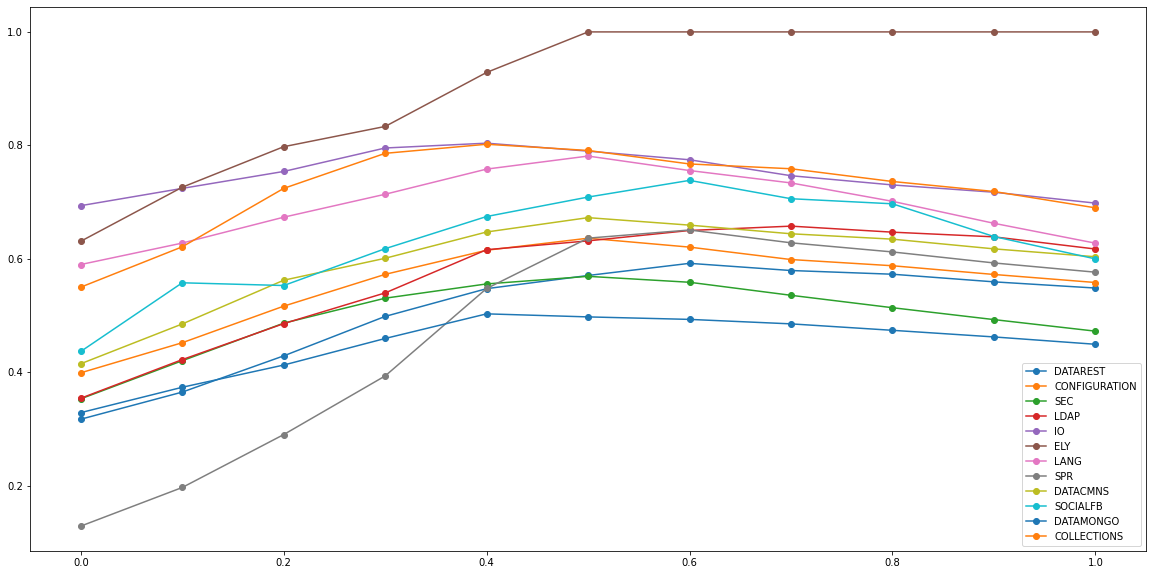

In [109]:
create_line_graph(alpha_MAP)

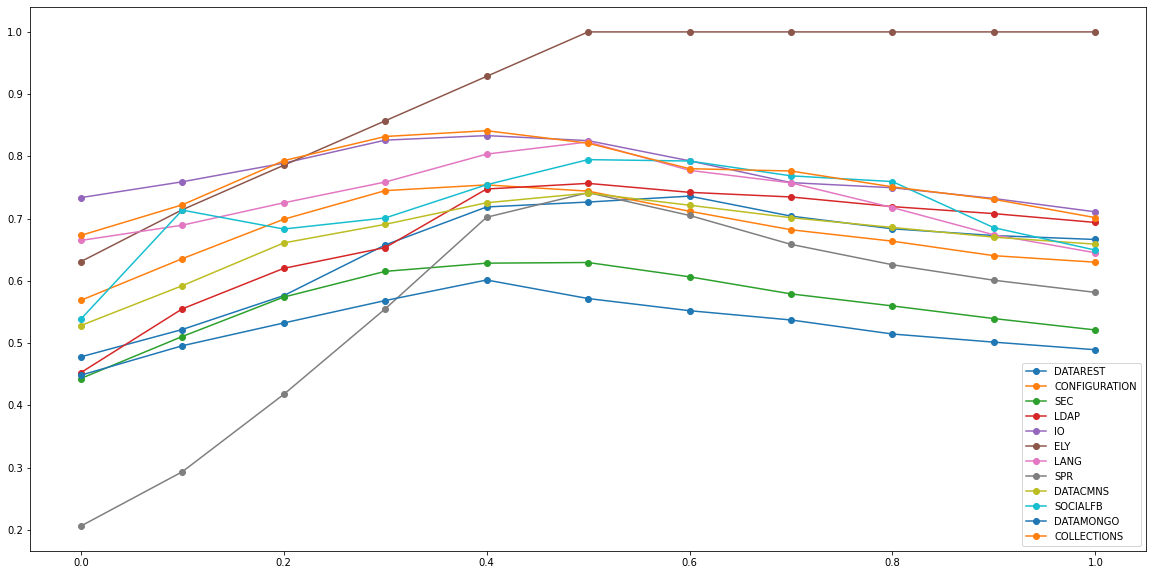

In [110]:
create_line_graph(alpha_MRR)

# 6 Comparing Method 1 with Method 2

In this section we will take the performance table from method 1 and compare it with the best performing alpha value performance table from method 2 (alpha value = 0.5).

## 6.1 Setup

In [111]:
method_1 = method_1_performance_table_df
best_method_2 = all_combined_alpha_performance_table[5]

In [112]:
method_1.head(12)

,MRR,MAP,Top 1,Top 1 (%),Top 5,Top 5 (%),Top 10,Top 10 (%)
DATAREST,0.477968,0.317208,41.0,34.453782,75.0,63.025210,89.0,74.789916
CONFIGURATION,0.568746,0.399042,53.0,43.801653,89.0,73.553719,106.0,87.603306
SEC,0.443140,0.353154,108.0,30.167598,227.0,63.407821,264.0,73.743017
LDAP,0.452596,0.354167,16.0,30.769231,31.0,59.615385,35.0,67.307692
IO,0.733792,0.693688,40.0,58.823529,62.0,91.176471,65.0,95.588235
ELY,0.630952,0.630952,3.0,42.857143,7.0,100.000000,7.0,100.000000
LANG,0.664944,0.589924,86.0,53.086420,136.0,83.950617,148.0,91.358025
SPR,0.206079,0.128763,13.0,10.000000,41.0,31.538462,56.0,43.076923
DATACMNS,0.528252,0.415011,58.0,40.000000,97.0,66.896552,107.0,73.793103
SOCIALFB,0.538475,0.436705,6.0,40.000000,10.0,66.666667,13.0,86.666667


In [113]:
best_method_2.head(12)

,MRR,MAP,Top 1,Top 1 (%),Top 5,Top 5 (%),Top 10,Top 10 (%)
DATAREST,0.726669,0.570582,74.0,62.184874,104.0,87.394958,115.0,96.638655
CONFIGURATION,0.744224,0.636309,76.0,62.809917,112.0,92.561983,117.0,96.694215
SEC,0.629543,0.569057,183.0,51.117318,279.0,77.932961,310.0,86.592179
LDAP,0.756650,0.631604,35.0,67.307692,45.0,86.538462,48.0,92.307692
IO,0.825327,0.789763,49.0,72.058824,66.0,97.058824,67.0,98.529412
ELY,1.000000,1.000000,7.0,100.000000,7.0,100.000000,7.0,100.000000
LANG,0.823212,0.781122,119.0,73.456790,153.0,94.444444,158.0,97.530864
SPR,0.741790,0.636403,83.0,63.846154,114.0,87.692308,120.0,92.307692
DATACMNS,0.740985,0.672555,95.0,65.517241,124.0,85.517241,131.0,90.344828
SOCIALFB,0.794815,0.708840,11.0,73.333333,14.0,93.333333,14.0,93.333333


## 6.2 Visualization Functions

In [114]:
def visualize_compare_methods(df, df2, data_metric):
    proj_x = df.index.to_numpy()
    metric1 = df[data_metric].to_numpy()
    metric2 = df2[data_metric].to_numpy()

    upper_lim = max(np.amax(metric1), np.amax(metric2))

    x_pos = np.arange(len(proj_x))
    plt.figure(figsize=(20,10))
    plt.xticks(x_pos, proj_x)
    width = 0.25
    plt.title(f'Comparing Method 1 and Method 2 {data_metric}')
    plt.ylabel('Percentage (%)')
    plt.ylim(0, upper_lim + 0.1*upper_lim)
    plt.bar(x_pos - width, metric1, width=width, label=f'Method 1 {data_metric}')
    plt.bar(x_pos, metric2,  width=width, label=f'Method 2 {data_metric}')
    plt.legend()

## 6.3 Creating Graphs

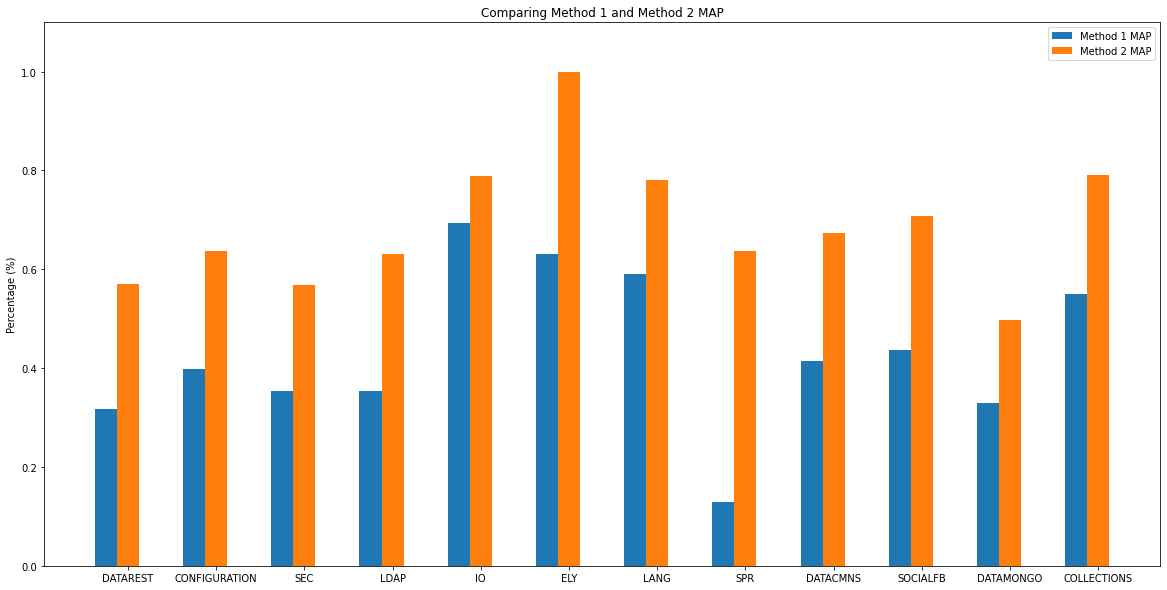

In [115]:
visualize_compare_methods(method_1, best_method_2, 'MAP')

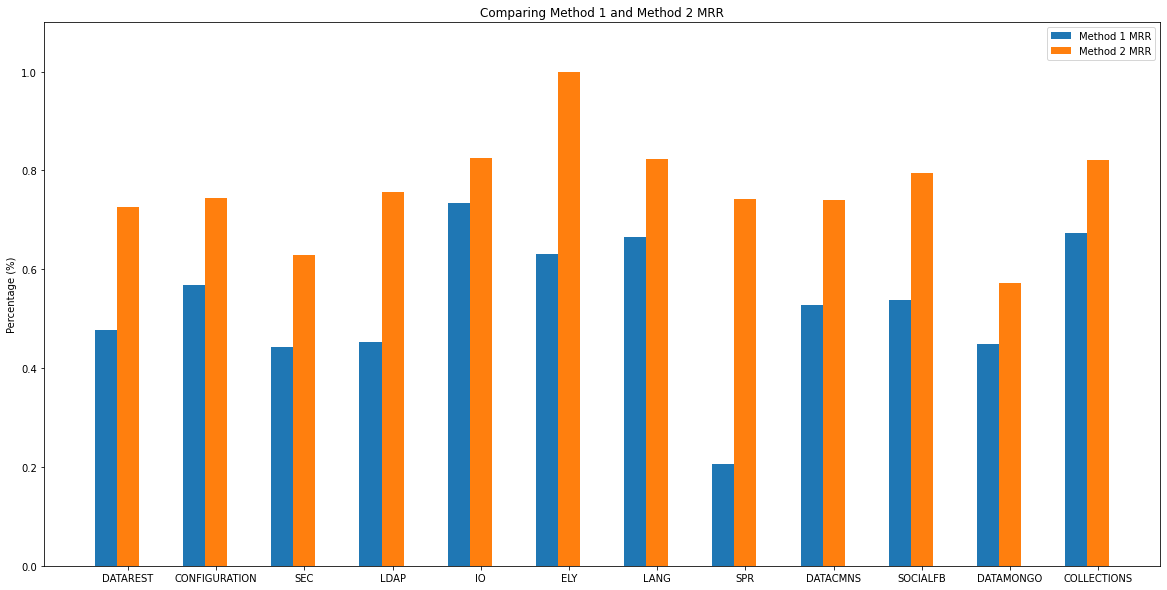

In [116]:
visualize_compare_methods(method_1, best_method_2, 'MRR')

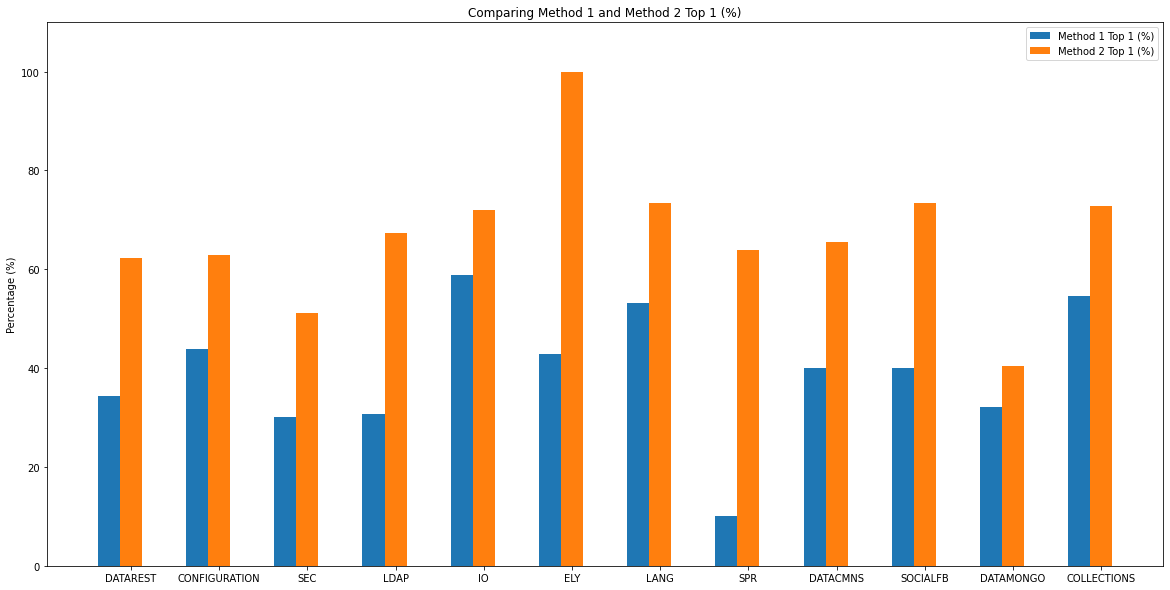

In [117]:
visualize_compare_methods(method_1, best_method_2, 'Top 1 (%)')

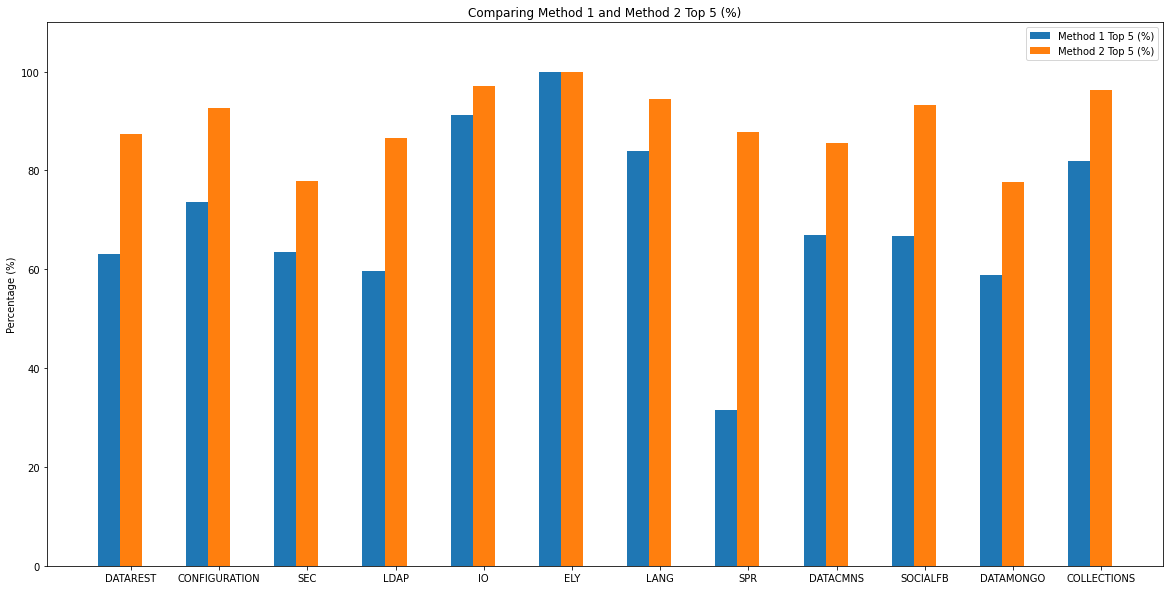

In [118]:
visualize_compare_methods(method_1, best_method_2, 'Top 5 (%)')

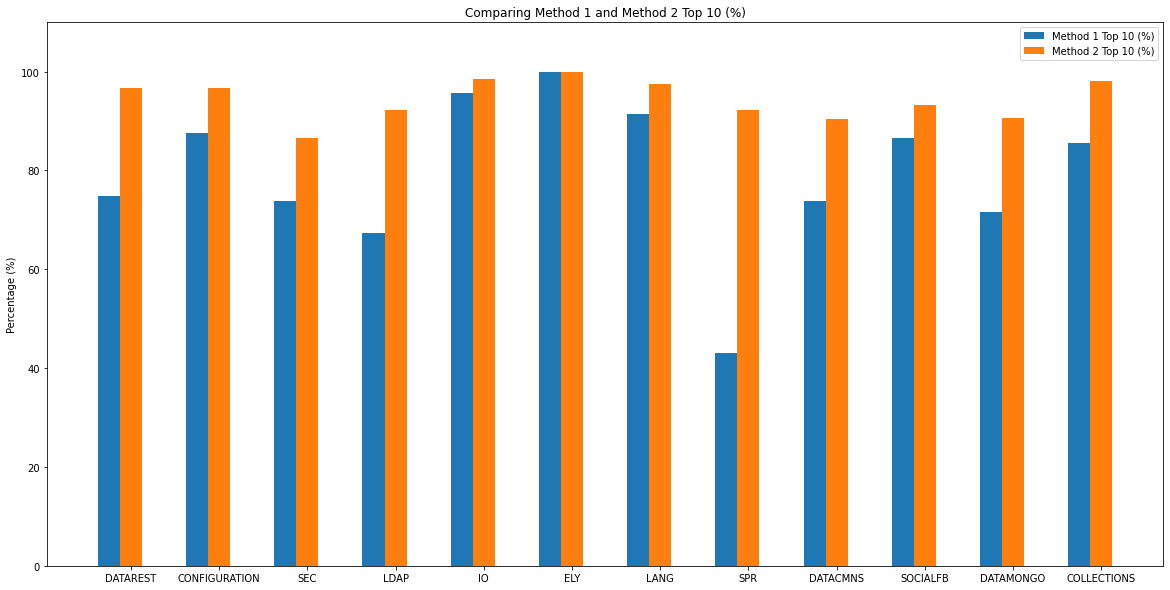

In [119]:
visualize_compare_methods(method_1, best_method_2, 'Top 10 (%)')

## 6.4 Conclusion

Method 2 with alpha value = 0.5 outperforms method 1 in every metric for every project